In [163]:
# 12-18-2022
# benjamin m hardy
# Purpose: demonstrate relationships dictating relative noise contributions from 
# some key references:

# great intro reference is Noise in MRI - Al macovski
# [1] https://pubmed.ncbi.nlm.nih.gov/8875425/
# another more recent interesting take:
# [2] https://ieeexplore.ieee.org/document/5910383

# great description of Q-relationship:
# [3] https://pubmed.ncbi.nlm.nih.gov/10680678/
# would be good to improve on this paper's assumptions and to show it experimentally.

# Overall great reference is Darasse and Ginefri
# [4] https://pubmed.ncbi.nlm.nih.gov/14652180/

# key question: How does temperature, coil size, conductivity of sample, influence noise contributions
# figure 4 in Darasse and Ginefri is the experimental demonstration we would want to show.
# imports:
from math import pi, sqrt, log10
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker


In [181]:
# use nice Latex typesetting
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans"
})
# fonts
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 17}

plt.rc('font', **font)

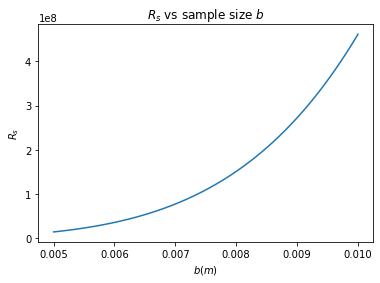

In [104]:
# figure 1: 
# sample resistance and coil resistance vs coil size
# for a uniform sphere (eq. 6 in ref [4], also hoult and Richards)

# First plotting: sample noise vs sample size, uniform sphere (ref[4] eq 6)
b = .005 # sample radius, m
sigma = .66 # conductivity of sample, S/m
omega = 2*pi*650e6 # resonance frequency, 650 MHz
cc = 1 # coupling coefficient (B1/Ic) B1 over the current in coil
rs = lambda sigma, omega, cc, b: 2*pi*sigma*omega**2 *cc**2 * b**5/15

number_b_points = 100
b_min = 0.005 # m
b_max = 0.01 # m
b_grid = np.linspace(b_min, b_max, number_b_points)
rs_vs_b = []
for b_index in range(number_b_points):
    rs_vs_b.append(rs(sigma, omega, cc, b_grid[b_index]))
    
plt.plot(b_grid, rs_vs_b)
plt.xlabel('$b (m)$')
plt.ylabel(r'$R_s$')
plt.title(r'$R_s$ vs sample size $b$')
plt.show()

# Next plotting: 

In [194]:
# Generating Equations [8] and [9] from Darasse and Ginefri 
# sample and coil contributions, simple circular SURFACE COIL model, 
# semi-infinite conductive sample

a = .005 # coil radius,(m)
n = 1 # number of turns
r = 0.001 # wire radius (m)
sigma = .66 # conductivity of sample, S/m
d = 0.001 # spacing, the distance of the coil from the sample (m)
mu_0 = 4*pi*1e-7 # magnetic permeability of free space, H/m 4*pi*1e-7
omega = 2*pi*650e6 # resonance frequency, 650 MHz
xia_over_r = 40 # experimental surface coil value (Kober et al MRM 2001).
# rt:
rho_c = 1.72e-8

# additional sources of resistance:
l = .005 # length of the leads 5mm
dwire = .0004 # 400 µm
#Rleads =  (l/dwire) * sqrt(mu_0*rho_c*self.f/pi) 
# capacitor
# Q = 1000
# calculate inductance
# technically the leads also contribute inductance but i am ignoring it
# # correctors
def Rcap(dwire,s,n,dcoil,lcoil,omega):
    Q = 500
    J = 2.33*log10(dwire/s) + .515
    K_v = [.01,.07,.15,.18,.21,.24,.25,.27,.28,.29,.3] # may be the table Bibek mentioned I should fix?
    if (n > 11):
        K = .3
    else:
        K = K_v[n-1]
    
    L = (9850*dcoil*n**2 / (4.5 + 10*(lcoil/dcoil))) - 628*dcoil*n*(J+K)
    L = L*1e-9
    #print(L)
    Ctune = 1/(L*(omega)**2)
    Rcap = 1/(omega*Q*Ctune)
    return Rcap

# need to estimate capacitance!
#Ctune = 1/(L*(omega)**2)
#Rcap = 1/(omega*Q*Ctune)

#rho_c = 15e-1*10e-8 # ohm*m, assuming RRR=20, T = 77 K. From https://copper.org/resources/properties/cryogenic/ 1.72e-8

rs_infinite_sample = lambda sigma, omega, mu_0, a, n, d: (2/(3*pi)) * sigma * mu_0**2 * omega**2 * n**2 * a**3 * np.arctan((pi*a)/(8*d))
rc_infinite_sample = lambda rho_c, mu_0, omega, n, xia_over_r: np.sqrt(0.5*rho_c*mu_0*omega*n**2*xia_over_r)
dcoil = a
lcoil = dcoil
rc_infinite_sample_leadsCap = lambda rho_c, mu_0, omega, n, xia_over_r, dwire, l, lcoil, dcoil: np.sqrt(0.5*rho_c*mu_0*omega*n**2*xia_over_r) + (l/dwire)*sqrt(mu_0*rho_c*omega/(2*pi*pi)) + Rcap(dwire,lcoil/n,n,dcoil,lcoil,omega)
# add other parts of circuit
#

c:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
c:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


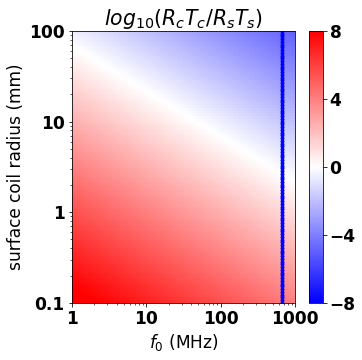

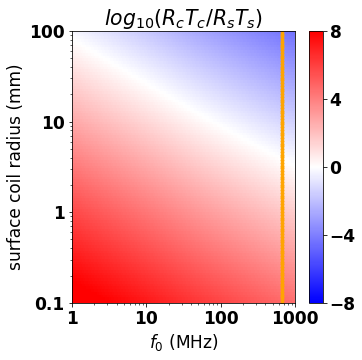

In [220]:
# let's try to recreate Figure 4, a coil resistance crossover graph, surface coil radius vs NMR frequency

T_s = 293 # K 
T_c = 293 # K
number_a_points = 100
a_min = 0.0001 # m
a_max = 0.01 # m

a_grid = np.logspace(-4, -1, number_a_points)

number_omega_points = 200
omega_min = 2*pi*67*1e6 # 2 * pi * mhz
omega_max = 2*pi*900*1e6 # 2 * pi * mhz

omega_grid = 2*pi* np.logspace(6, 9, number_omega_points)

rsts_space = np.zeros((number_a_points, number_omega_points))
rctc_space = np.zeros((number_a_points, number_omega_points))
rctc_leadsCap_space = np.zeros((number_a_points, number_omega_points))

for a_index in range(number_a_points):
    for omega_index in range(number_omega_points):
        rsts_space[a_index, omega_index] = rs_infinite_sample(sigma, omega_grid[omega_index], mu_0, a_grid[a_index], n, .5*a_grid[a_index]) * T_s
        rctc_space[a_index, omega_index] = rc_infinite_sample(rho_c, mu_0, omega_grid[omega_index], n, xia_over_r) * T_c
        rctc_leadsCap_space[a_index, omega_index] = rc_infinite_sample_leadsCap(rho_c, mu_0, omega_grid[omega_index], n, xia_over_r,.0004,l,.0004,a) * T_c
        

# result: yeah, it looks linear! 
plot_min = -25
plot_max = 25
fig, ax = plt.subplots(figsize=(5,5))
#plt.subplot(1,2,1)
# plt.imshow(np.flipud(np.log(rsts_space/rctc_space)),extent = [omega_min, omega_max, a_min, a_max], cmap='RdBu', vmin=plot_min, vmax=plot_max) # plot log to easily identify where predominance domains switch
c = ax.pcolormesh(omega_grid/(1e6*2*pi), a_grid*1000, np.log10(rctc_space/rsts_space), cmap='bwr',vmin=-8,vmax=8)
#c = ax.pcolor(omega_grid/(1e6*2*pi), a_grid*1000, rctc_space/rsts_space, cmap='cool')
#ax.loglog()
plt.xscale('log')
plt.yscale('log')
ax=plt.gca() #get the current axes
#PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
#plt.colorbar(PCM, ax=ax) 
cb = fig.colorbar(c, ax=ax)
cb.set_ticks([-8, -4, 0, 4, 8])

plt.xlabel('$f_0$ (MHz)')
plt.ylabel('surface coil radius (mm)')
plt.title('$log_{10}(R_cT_c/R_sT_s$)')

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(x),0)))).format(x)))
plt.scatter(omega_grid[187]/(1e6*2*pi)*np.ones(a_grid.shape),a_grid*1000,color='blue', marker='.')
#plt.show()

#
#plt.subplot(1,2,2)
#v = np.log10(rctc_space/rsts_space)
#plt.plot(a_grid[100,:], v[:,650])
#plt.xlabel('surface coil radius (mm)')
#plt.ylabel('$log_{10}(R_cT_c/R_sT_s$)')

# same thing but with caps and leads

# result: yeah, it looks linear! 
plot_min = -25
plot_max = 25
fig, ax = plt.subplots(figsize=(5,5))
#plt.subplot(1,2,1)
# plt.imshow(np.flipud(np.log(rsts_space/rctc_space)),extent = [omega_min, omega_max, a_min, a_max], cmap='RdBu', vmin=plot_min, vmax=plot_max) # plot log to easily identify where predominance domains switch
c = ax.pcolormesh(omega_grid/(1e6*2*pi), a_grid*1000, np.log10(rctc_leadsCap_space/rsts_space), cmap='bwr',vmin=-8.0,vmax=8.0)

#c = ax.pcolor(omega_grid/(1e6*2*pi), a_grid*1000, rctc_space/rsts_space, cmap='cool')
#ax.loglog()
plt.xscale('log')
plt.yscale('log')
ax=plt.gca() #get the current axes
#PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
#plt.colorbar(PCM, ax=ax) 

cb = fig.colorbar(c, ax=ax)
cb.set_ticks([-8, -4, 0, 4, 8])

plt.xlabel('$f_0$ (MHz)')
plt.ylabel('surface coil radius (mm)')
plt.title('$log_{10}(R_cT_c/R_sT_s$)')

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(x),0)))).format(x)))
plt.scatter(omega_grid[187]/(1e6*2*pi)*np.ones(a_grid.shape),a_grid*1000,color='orange', marker='.')

[-7.5 -5.  -2.5  0.   2.5  5.   7.5]


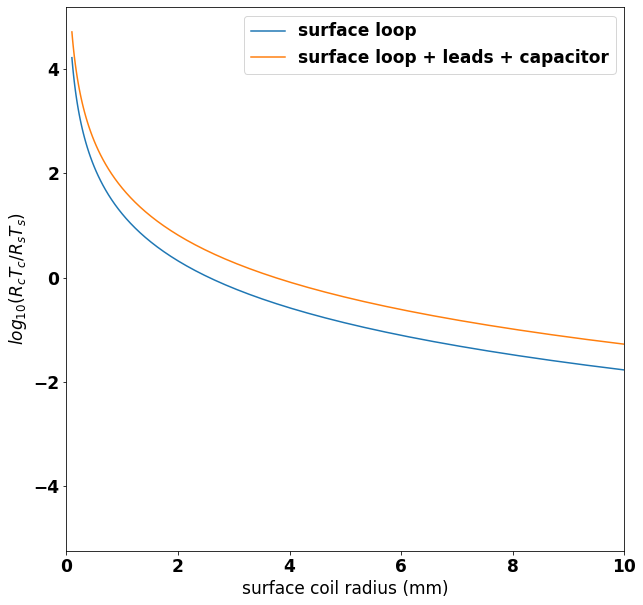

In [199]:
v = np.log10(rctc_space/rsts_space)
v2 = np.log10(rctc_leadsCap_space/rsts_space)

plt.subplots(figsize=(10,10))
plt.plot(a_grid*1000, v[:,187],label='surface loop')
plt.plot(a_grid*1000, v2[:,187],label='surface loop + leads + capacitor')
plt.xlabel('surface coil radius (mm)')
plt.ylabel('$log_{10}(R_cT_c/R_sT_s)$')
plt.xlim([0,10])
plt.legend()



In [83]:
# essentially this isn't including the resistance of the other parts of the circuit

0.3010299956639812